In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [124]:
df = pd.read_csv("framingham.csv")
df.dropna(axis=0, inplace=True)
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

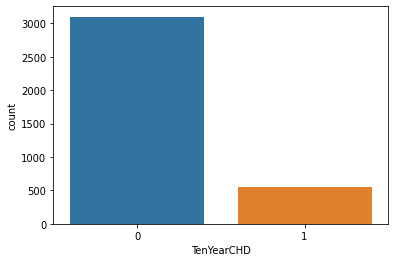

In [125]:
sns.countplot(x="TenYearCHD", data=df)
plt.show()

In [126]:
#check correlation matrix
df.corr()["TenYearCHD"]

male               0.091745
age                0.233810
education         -0.063068
currentSmoker      0.019176
cigsPerDay         0.052159
BPMeds             0.089116
prevalentStroke    0.048351
prevalentHyp       0.181556
diabetes           0.093397
totChol            0.091127
sysBP              0.222885
diaBP              0.150342
BMI                0.081931
heartRate          0.020523
glucose            0.121942
TenYearCHD         1.000000
Name: TenYearCHD, dtype: float64

In [127]:
#Correlation Values are low. Check for Dependence between variables and TenYearCHD
x = df.iloc[:, :15]
y = df.iloc[:, -1]
x.shape, y.shape

((3656, 15), (3656,))

In [128]:
#check for dependency
chi_square, pvalues = chi2(x,y)

dependence_df = pd.DataFrame((chi_square, pvalues)).transpose()
dependence_df.index = x.columns
dependence_df.columns = ["chi_square", "pvalues"]
dependence_df

,chi_square,pvalues
male,17.120430,3.508289e-05
age,295.507761,3.136918e-66
education,7.679797,5.584246e-03
currentSmoker,0.686913,4.072163e-01
cigsPerDay,156.567318,6.363520e-36
BPMeds,28.153003,1.120936e-07
prevalentStroke,8.497823,3.555717e-03
prevalentHyp,82.967184,8.342694e-20
diabetes,31.027987,2.543345e-08
totChol,249.153078,3.972625e-56


In [129]:
#feature_selection
x_var = [dependence_df.index[i] for i in range(len(dependence_df)) if dependence_df["pvalues"][i] < 0.05]
new_x = df[x_var]

#scale values of x to be between 0 and 1
scaler = MinMaxScaler()
df_x = scaler.fit_transform(new_x)

#train_test_split
x_train, x_test, y_train, y_test = tts(df_x, y, test_size=0.3, random_state=42)

#predict TenYearCHD using LogisticRegression
model = LogisticRegression().fit(x_train, y_train)
y_hat = model.predict(x_test)

#check accuracy using 
print("Percentage Accuracy\t" + str(f1_score(y_test, y_hat)*100))

Percentage Accuracy	13.471502590673579


According to Framingham Risk Score Study, Probability values for risk of TenYearCHD greater than or equal to 20% indicate high risk of TenYearCHD

Reference: https://en.wikipedia.org/wiki/Framingham_Risk_Score

In [130]:
#change classification threshold to 0.2
prob = model.predict_proba(x_test)[:, 1]
Y_hat = [1 if prob[i] > 0.2 else 0 for i in range(len(prob))]
print("Percentage Accuracy\t"+ str(f1_score(y_test, Y_hat)*100))

Percentage Accuracy	38.443935926773456


Check Distributions in Variables

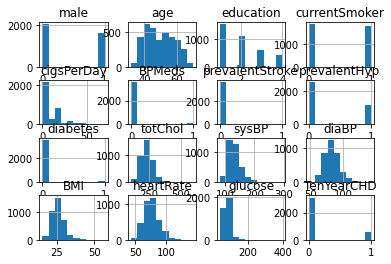

In [131]:
df.hist()
plt.show()

Group into different Age Groups

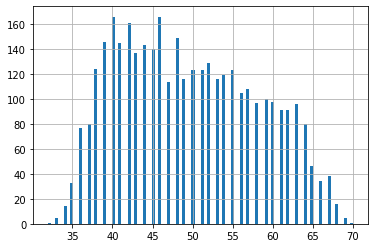

In [132]:
df["age"].hist(bins=100)
plt.show()

In [133]:
age_bins = [30, 39, 49, 59, 69, 79]
age_labels = ["30-39", "40-49", "50-59", "60-69", "70-79"]
df["age_grp"] = pd.cut(df["age"], bins=age_bins, labels=age_labels)
cols = [df.columns[-1]]
for i in range(len(df.columns[:16])):
  cols.append(df.columns[i])

df = df[cols]
df.sample(1)

,age_grp,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
89,40-49,1,41,2.0,0,0.0,0.0,0,0,0,274.0,121.0,61.5,25.42,80.0,76.0,0


Causes of Cornary Heart Disease:
1. Smoking and Secondhand Smoke Exposure
2. High blood pressure
3. High low-density lipoprotein (LDL) cholesterol 
4. Diabetes
4. Obesity, unhealthy diet, and Physical inactivity

reference: https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm

Table Visualization:

Group exposures by confounder variables

In [134]:
#Smoking Class
smoking = df.groupby(["male", "age_grp","currentSmoker"]).agg({"TenYearCHD":"sum"}).transpose()
smoking

male              0                                               1           \
age_grp       30-39    40-49     50-59     60-69     70-79    30-39    40-49   
currentSmoker     0  1     0   1     0   1     0   1     0  1     0  1     0   
TenYearCHD        0  7    23  34    65  35    74  12     0  0     5  9    18   

male                                            
age_grp           50-59     60-69     70-79     
currentSmoker   1     0   1     0   1     0  1  
TenYearCHD     63    50  80    37  45     0  0

In [135]:
#Diabetes Class
diabetes = df.groupby(["male", "age_grp","diabetes"]).agg({"TenYearCHD":"sum"}).transpose()
diabetes

male           0                                            1              \
age_grp    30-39    40-49    50-59    60-69    70-79    30-39    40-49      
diabetes       0  1     0  1     0  1     0  1     0  1     0  1     0  1   
TenYearCHD     7  0    53  4    92  8    83  3     0  0    14  0    79  2   

male                                    
age_grp    50-59     60-69    70-79     
diabetes       0   1     0  1     0  1  
TenYearCHD   120  10    74  8     0  0

In [136]:
#Group into Obese(1) and Non-Obese(0)
bmi_class = [1 if i >= 30 else 0 for i in range(len(df["BMI"]))] #classification for obese obtained from CDC website
df["BMI"] = bmi_class
bmi = df.groupby(["male","age_grp","BMI"]).agg({"TenYearCHD": "sum"}).transpose()
bmi

male           0                                               1            \
age_grp    30-39    40-49     50-59     60-69     70-79    30-39     40-49   
BMI            0  1     0   1     0   1     0   1     0  1     0   1     0   
TenYearCHD     1  6     1  56     1  99     3  83     0  0     0  14     1   

male                                          
age_grp        50-59      60-69     70-79     
BMI          1     0    1     0   1     0  1  
TenYearCHD  80     0  130     0  82     0  0

In [137]:
#Blood Pressure Class
highBp = df.groupby(["male","age_grp","prevalentHyp"]).agg({"TenYearCHD": "sum"}).transpose()
highBp

male             0                                               1           \
age_grp      30-39    40-49     50-59     60-69     70-79    30-39    40-49   
prevalentHyp     0  1     0   1     0   1     0   1     0  1     0  1     0   
TenYearCHD       5  2    42  15    39  61    21  65     0  0    11  3    48   

male                                           
age_grp          50-59     60-69     70-79     
prevalentHyp   1     0   1     0   1     0  1  
TenYearCHD    33    69  61    38  44     0  0

Store Data Per Age Group and Stratify Each Group By Gender

In [138]:
for i in range(3,8):
  age_data = f"data_{i}0_{i}9" 
  exec(f'{age_data} = df[df["age_grp"] == f"{i}0-{i}9"]')

  male_data = f"male_{i}0_{i}9"
  exec(f'{male_data} = {age_data}[{age_data}["male"]==1]')

  female_data = f"female_{i}0_{i}9"
  exec(f'{female_data} = {age_data}[{age_data}["male"]==0]')

In [140]:
#check
male_30_39.sample(2)

,age_grp,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3387,30-39,1,37,2.0,1,30.0,0.0,0,0,0,249.0,112.0,70.0,1,56.0,76.0,0
1353,30-39,1,33,2.0,0,0.0,0.0,0,1,0,165.0,141.5,95.0,1,54.0,77.0,0


create functions for calculating adjusted risk ratio and probability values

In [156]:
##exposure is a string value
def structure(data_frame, exposure, outcome):
  a = len(data_frame[(data_frame[exposure]==1)&(data_frame[outcome]==1)])
  b = len(data_frame[(data_frame[exposure]==1)&(data_frame[outcome]==0)])
  c = len(data_frame[(data_frame[exposure]==0)&(data_frame[outcome]==1)])
  d = len(data_frame[(data_frame[exposure]==0)&(data_frame[outcome]==0)])
  tot_r1 = a+b
  tot_r2 = c+d
  tot_c1 = a+c
  tot_c2 = b+d
  tot_c3 = tot_r1 + tot_r2
  mdl = pd.DataFrame([[a, b, tot_r1], [c, d, tot_r2], [tot_c1, tot_c2, tot_c3]], 
                              columns = [outcome, "no_"+outcome, "total"], 
                              index = [exposure, "no_"+exposure, "Total"])
  return mdl, exposure, outcome

##calculate Adjusted R
def adj_r(data_frame, exposure, outcome):
  model, exposure, outcome = structure(data_frame, exposure, outcome)
  no_outcome = "no_"+ outcome
  no_exposure = "no_"+ exposure
  numerator = (model[outcome][exposure] * (model[outcome][no_exposure] + model[no_outcome][no_exposure]))/(model["total"]["Total"])
  denominator = (model[outcome][no_exposure] * (model[outcome][exposure] + model[no_outcome][exposure]))/(model["total"]["Total"])
  return numerator, denominator

def getProba(data_frame, exposure, outcome):
  model, exposure, outcome = structure(data_frame, exposure, outcome)
  no_outcome = "no_"+outcome
  no_exposure = "no_"+exposure
  proba_outcome_given_unexposed = model[outcome][no_exposure]/model["total"][no_exposure]
  return proba_outcome_given_unexposed

In [157]:
#check
structure_test = structure(data_30_39, "currentSmoker", "TenYearCHD")[0]
structure_test

,TenYearCHD,no_TenYearCHD,total
currentSmoker,16,262,278
no_currentSmoker,5,197,202
Total,21,459,480


Further Data Processing

In [144]:
#create new df for further data processing
processed = df[["age_grp", "age", "currentSmoker", "prevalentHyp", "diabetes", "BMI", "TenYearCHD"]]

In [145]:
processed[processed["age"]>=70]

,age_grp,age,currentSmoker,prevalentHyp,diabetes,BMI,TenYearCHD
3137,70-79,70,0,1,0,1,0


Since there is just one person in the age group of 70-79, let us ignore that for now

In [ ]:
processed.drop(3137, axis=0, inplace=True)
processed.reset_index(inplace=True)

In [147]:
processed.head(1)

,index,age_grp,age,currentSmoker,prevalentHyp,diabetes,BMI,TenYearCHD
0,0,30-39,39,0,0,0,0,0


Change values of Exposure Variables in Processed Table to Probability values such that probability of exposed individuals in each age group is a multiple of the probability values of unexposed individuals given that confounding has been taken into consideration

In [ ]:
#calculating Risk Ratios, Adjusted_Risk Ratios and Probabilities

exposures = ["currentSmoker", "prevalentHyp", "diabetes", "BMI"]

for i in range(len(exposures)):
  #Age 30-39
  male_RRnum_30_39, male_RRdenom_30_39 = adj_r(male_30_39, exposures[i], "TenYearCHD")
  female_RRnum_30_39, female_RRdenom_30_39 = adj_r(female_30_39, exposures[i], "TenYearCHD")
  adjusted_R_30_39 = (male_RRnum_30_39 + female_RRnum_30_39)/(male_RRdenom_30_39 + female_RRdenom_30_39)

  #Age 40-49
  male_RRnum_40_49, male_RRdenom_40_49 = adj_r(male_40_49, exposures[i], "TenYearCHD")
  female_RRnum_40_49, female_RRdenom_40_49 = adj_r(female_40_49, exposures[i], "TenYearCHD")
  adjusted_R_40_49 = (male_RRnum_40_49 + female_RRnum_40_49)/(male_RRdenom_40_49 + female_RRdenom_40_49)

  #Age 50-59
  male_RRnum_50_59, male_RRdenom_50_59 = adj_r(male_50_59, exposures[i], "TenYearCHD")
  female_RRnum_50_59, female_RRdenom_50_59 = adj_r(female_50_59, exposures[i], "TenYearCHD")
  adjusted_R_50_59 = (male_RRnum_50_59 + female_RRnum_50_59)/(male_RRdenom_50_59 + female_RRdenom_50_59)

  #Age 60-69
  male_RRnum_60_69, male_RRdenom_60_69 = adj_r(male_60_69, exposures[i], "TenYearCHD")
  female_RRnum_60_69, female_RRdenom_60_69 = adj_r(female_60_69, exposures[i], "TenYearCHD")
  adjusted_R_60_69 = (male_RRnum_60_69 + female_RRnum_60_69)/(male_RRdenom_60_69 + female_RRdenom_60_69)

  for j in range(len(processed)):
    #Age 30-39
    if processed["age_grp"][j] == "30-39" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_30_39, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "30-39" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_30_39, exposures[i], "TenYearCHD")* adjusted_R_30_39
  
    #Age 40-49
    elif processed["age_grp"][j] == "40-49" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_40_49, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "40-49" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_40_49, exposures[i], "TenYearCHD")* adjusted_R_40_49
  
    #Age 50-59
    elif processed["age_grp"][j] == "50-59" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_50_59, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "50-59" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_50_59, exposures[i], "TenYearCHD")* adjusted_R_50_59

    #Age 60-69
    elif processed["age_grp"][j] == "60-69" and processed[exposures[i]][j]==0:
      processed.loc[j, exposures[i]] = getProba(data_60_69, exposures[i], "TenYearCHD")
    elif processed["age_grp"][j] == "60-69" and processed[exposures[i]][j]==1:
      processed.loc[j, exposures[i]] = getProba(data_60_69, exposures[i], "TenYearCHD")* adjusted_R_60_69

New Prediction Using Processed Table

In [154]:
#x and y variables for processed table
x_pr = processed[["age","currentSmoker", "prevalentHyp", "diabetes", "BMI"]]
y_pr = processed["TenYearCHD"]

#train_test_split for processed table
x_train_pr, x_test_pr, y_train_pr, y_test_pr = tts(x_pr, y_pr, test_size=0.4, random_state=4)

#predict TenYearCHD using LogisticRegression
model_pr = LogisticRegression().fit(x_train_pr, y_train_pr)

#classification threshold = 0.2
prob_pr = model_pr.predict_proba(x_test_pr)[:, 1]
y_hat_pr = [1 if prob_pr[i] > 0.2 else 0 for i in range(len(prob_pr))]
print("Percentage Accuracy\t"+ str(f1_score(y_test_pr, y_hat_pr)*100))

Percentage Accuracy	37.47747747747748


Percentage Accuracy decreased. Review Method and Revisit